In [1]:
import os

from torch.utils.data import DataLoader
from medmnist.dataset import BloodMNIST
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import *
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import torch

In [2]:
ROOT_PATH = '/'.join(os.getcwd().split('/')[:-2])
DATA_PATH = f'{ROOT_PATH}/dataset/blood_mnist'

BATCH_SIZE = 64 
INIT_LR    = 1e-3
EPOCHS     = 10
DEVICE     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DECAY      = 1e-5

DATA_PATH

'/home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/dataset/blood_mnist'

In [3]:
transform = {}
transform['train'] = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.Resize((28, 28)),
                                    transforms.ToTensor()
                                ])

transform['valid'] = transforms.Compose([
                                    transforms.Resize((28, 28)),
                                    transforms.ToTensor()
                                ])

In [4]:
train_dataset = BloodMNIST(split  = 'train', download  = True,
                           as_rgb = True   , transform = transform['train'],
                           root   = DATA_PATH) 

valid_dataset = BloodMNIST(split  = 'val', download  = True,
                           as_rgb =  True, transform = transform['valid'], 
                           root   = DATA_PATH)

test_dataset  = BloodMNIST(split  = 'test', download  = True,
                           as_rgb =   True, transform = transform['valid'],
                           root   = DATA_PATH)

Using downloaded and verified file: /home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/dataset/blood_mnist/bloodmnist.npz
Using downloaded and verified file: /home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/dataset/blood_mnist/bloodmnist.npz
Using downloaded and verified file: /home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/dataset/blood_mnist/bloodmnist.npz


In [5]:
train_loader = DataLoader(train_dataset, shuffle = True,  batch_size = BATCH_SIZE)
valid_loader = DataLoader(valid_dataset, shuffle = False, batch_size = BATCH_SIZE)
test_loader  = DataLoader(test_dataset , shuffle = False, batch_size = BATCH_SIZE)

In [6]:
class BloodNet(nn.Module):
    
    def __init__(self, n_classes):
        
        super(BloodNet, self).__init__()
        
        self.conv1   = self.ConvBlock(3,  16, 3)
        self.conv2   = self.ConvBlock(16, 16, 3)
        self.conv3   = self.ConvBlock(16, 64, 3)
        self.conv4   = self.ConvBlock(64, 64, 3)
        self.conv5   = self.ConvBlock(64, 64, 3, 1)
        self.pooling = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.linear  = self.LinearBlock(64, n_classes)
        
        
    def ConvBlock(self, in_feats, out_feats, kernel_size = 3, padding = None):
        
        Conv2d = nn.Conv2d(in_feats, out_feats, kernel_size = kernel_size) \
                if padding == None else nn.Conv2d(in_feats, out_feats, kernel_size = kernel_size, padding = padding)
            
        layers = nn.Sequential(
                    Conv2d,
                    nn.BatchNorm2d(out_feats),
                    nn.ReLU()
                )
        
        return layers
    
    
    def LinearBlock(self, in_feats, n_classes):
        
        layers = nn.Sequential(
                    nn.Linear(in_feats * 4 * 4, 128),
                    nn.ReLU(),
                    nn.Linear(128, 128),
                    nn.ReLU(),
                    nn.Linear(128, n_classes)
                )
        
        return layers
    
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.pooling(self.conv2(x))
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pooling(self.conv5(x))
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        
        return x

In [7]:
n_classes = len(set(train_dataset.labels.T.tolist()[0]))
model     = BloodNet(n_classes).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = model.parameters(), lr = INIT_LR, 
                       weight_decay = DECAY)

In [8]:
history          = {
                        'train' : {
                                    'loss' : [], 'accuracy' : [], 'f1' : []
                                },
    
                        'valid' : {
                                'loss' : [], 'accuracy' : [], 'f1' : []
                            },
                    }


def train(model, train_loader, optimizer):
    
    total_loss    = 0
    correct       = 0
    
    gt, predicted = [], []
    model.train()
    
    for image, label in tqdm(train_loader):
        
        image       = image.float().to(DEVICE)
        label       = label.to(DEVICE).squeeze().long()
        
        outputs     = model(image)
        _, preds    = torch.max(outputs, 1)
        loss        = criterion(outputs, label)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
        correct    += torch.sum(preds == label.data)
        predicted  += preds.detach().cpu().numpy().tolist()
        gt         += label.detach().cpu().numpy().tolist()
        
    
    avg_loss = total_loss / len(train_loader)
    accuracy =    correct / (len(train_loader) * BATCH_SIZE)
    accuracy = float(accuracy.detach().cpu().numpy())
    f1       = f1_score(gt,predicted, average = 'weighted')
    
    print(f'[TRAIN] loss : {avg_loss:.2f} | accuracy : {accuracy:.2f} | f1 : {f1:.2f}')
    history['train']['loss'].append(avg_loss)
    history['train']['accuracy'].append(accuracy)
    history['train']['f1'].append(f1)
    
    
def valid(model, valid_loader):
    
    total_loss, correct =  0, 0
    gt, predicted       = [], []
    
    model.eval()
    with torch.no_grad():
        
        for image, label in tqdm(valid_loader):
            
            image    = image.float().to(DEVICE)
            label    = label.to(DEVICE).squeeze().long()
            
            outputs  = model(image)
            loss     = criterion(outputs, label)
            _, preds = torch.max(outputs, 1)
            
            total_loss += loss.item()
            correct    += torch.sum(preds == label.data)
            
            predicted  += preds.detach().cpu().numpy().tolist()
            gt         += label.detach().cpu().numpy().tolist()
            
    
    avg_loss = total_loss / len(valid_loader)
    accuracy = correct   / (len(valid_loader) * BATCH_SIZE)
    accuracy = float(accuracy.detach().cpu().numpy())
    f1       = f1_score(gt, predicted, average = 'weighted')
    
    print(f'[VALID] loss : {avg_loss:.2f} | accuracy : {accuracy:.2f} | f1 : {f1:.2f}')
    history['valid']['loss'].append(avg_loss)
    history['valid']['accuracy'].append(accuracy)
    history['valid']['f1'].append(f1)
    
    return f1


def run(model, train_loader, valid_loader):
    
    early_stopping_cnt = 0
    best_f1            = -1
    
    for epoch in range(EPOCHS):
        
        print(f'[{epoch + 1} / {EPOCHS}]')
        train(model, train_loader, optimizer)
        f1 = valid(model, valid_loader)
        
        if f1 > best_f1:
            
            os.makedirs('models/', exist_ok = True)
            best_f1 = f1
            early_stopping_cnt = 0
            
            torch.save(model, 'models/best_model.pt')
            print(f'save model with f1 : {f1:.2f}')
            
            
        else:
            early_stopping_cnt += 1
            if early_stopping_cnt >= 5:
                print(f'Training Stopped by Early stopping counter : {early_stopping_counter}')
                break
        

In [9]:
run(model, train_loader, valid_loader)

[1 / 10]


100%|██████████| 187/187 [00:04<00:00, 41.66it/s]


[TRAIN] loss : 0.56 | accuracy : 0.80 | f1 : 0.79


100%|██████████| 27/27 [00:00<00:00, 137.85it/s]

[VALID] loss : 0.56 | accuracy : 0.80 | f1 : 0.81


save model with f1 : 0.81
[2 / 10]


100%|██████████| 187/187 [00:02<00:00, 77.03it/s]


[TRAIN] loss : 0.34 | accuracy : 0.87 | f1 : 0.88


100%|██████████| 27/27 [00:00<00:00, 138.48it/s]

[VALID] loss : 0.36 | accuracy : 0.85 | f1 : 0.86


save model with f1 : 0.86
[3 / 10]


100%|██████████| 187/187 [00:02<00:00, 77.16it/s]


[TRAIN] loss : 0.26 | accuracy : 0.90 | f1 : 0.90


100%|██████████| 27/27 [00:00<00:00, 138.69it/s]

[VALID] loss : 0.22 | accuracy : 0.91 | f1 : 0.92


save model with f1 : 0.92
[4 / 10]


100%|██████████| 187/187 [00:02<00:00, 77.12it/s]


[TRAIN] loss : 0.23 | accuracy : 0.92 | f1 : 0.92


100%|██████████| 27/27 [00:00<00:00, 137.92it/s]


[VALID] loss : 0.22 | accuracy : 0.91 | f1 : 0.92
[5 / 10]


100%|██████████| 187/187 [00:02<00:00, 77.05it/s]


[TRAIN] loss : 0.21 | accuracy : 0.92 | f1 : 0.92


100%|██████████| 27/27 [00:00<00:00, 138.73it/s]


[VALID] loss : 0.24 | accuracy : 0.90 | f1 : 0.91
[6 / 10]


100%|██████████| 187/187 [00:02<00:00, 77.18it/s]


[TRAIN] loss : 0.18 | accuracy : 0.93 | f1 : 0.93


100%|██████████| 27/27 [00:00<00:00, 137.20it/s]


[VALID] loss : 0.35 | accuracy : 0.86 | f1 : 0.87
[7 / 10]


100%|██████████| 187/187 [00:02<00:00, 76.91it/s]


[TRAIN] loss : 0.16 | accuracy : 0.94 | f1 : 0.94


100%|██████████| 27/27 [00:00<00:00, 138.03it/s]


[VALID] loss : 0.42 | accuracy : 0.85 | f1 : 0.85
[8 / 10]


100%|██████████| 187/187 [00:02<00:00, 77.12it/s]


[TRAIN] loss : 0.15 | accuracy : 0.95 | f1 : 0.95


100%|██████████| 27/27 [00:00<00:00, 138.34it/s]

[VALID] loss : 0.19 | accuracy : 0.93 | f1 : 0.94


save model with f1 : 0.94
[9 / 10]


100%|██████████| 187/187 [00:02<00:00, 76.90it/s]


[TRAIN] loss : 0.16 | accuracy : 0.94 | f1 : 0.94


100%|██████████| 27/27 [00:00<00:00, 138.40it/s]


[VALID] loss : 0.28 | accuracy : 0.89 | f1 : 0.90
[10 / 10]


100%|██████████| 187/187 [00:02<00:00, 77.02it/s]


[TRAIN] loss : 0.15 | accuracy : 0.95 | f1 : 0.95


100%|██████████| 27/27 [00:00<00:00, 135.29it/s]


[VALID] loss : 0.17 | accuracy : 0.93 | f1 : 0.94


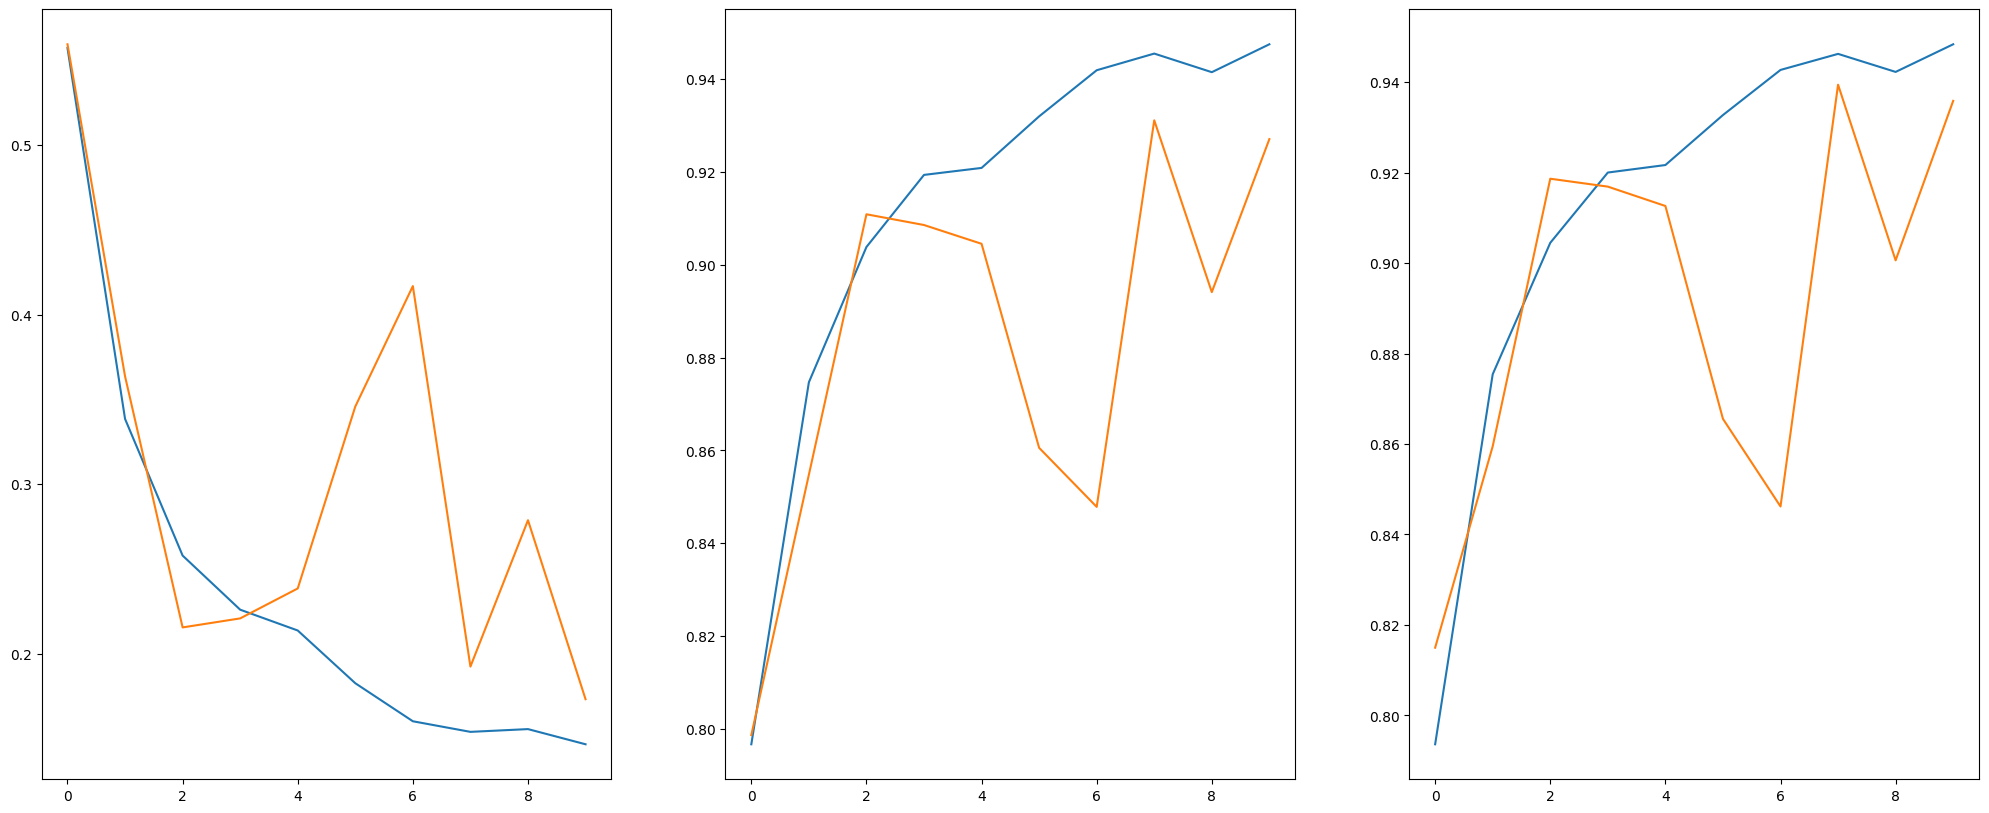

In [10]:
_, axes = plt.subplots(1, 3, figsize = (25, 10))

metrics = ['loss', 'accuracy', 'f1']

for idx, metric in enumerate(metrics):
    
    axes[idx].plot(range(EPOCHS), history['train'][metric],
                   range(EPOCHS), history['valid'][metric])

In [11]:
f1 = valid(model, test_loader)

100%|██████████| 54/54 [00:00<00:00, 138.06it/s]

[VALID] loss : 0.20 | accuracy : 0.92 | f1 : 0.93
